In [94]:
# Compare Algorithms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import sqlalchemy

%matplotlib inline 

engine = sqlalchemy.create_engine('postgresql://postgres:postgres@db/postgres')
df = pd.read_sql_query('SELECT * \
FROM aggregated_monthly_student_answers as m11 \
JOIN aggregated_monthly_student_answers as m10 ON m11.user_id = m10.user_id AND m10.aggregated_start_month = 10 \
JOIN aggregated_monthly_student_answers as m9 ON m11.user_id = m9.user_id AND m9.aggregated_start_month = 9 \
JOIN aggregated_monthly_student_answers as m8 ON m11.user_id = m8.user_id AND m8.aggregated_start_month = 8 \
WHERE m11.aggregated_start_month = 11 \
LIMIT 1000000',con=engine)

columns = []

for i,column in enumerate(df.columns):    
    if i < 8:
        columns.append(column + '_11')
    elif i >= 8 and i <= 15:
        columns.append(column + '_10')
    elif i >= 16 and i <= 23:
        columns.append(column + '_9')
    else:
        columns.append(column + '_8')
     
df.columns = columns

for n in ['8', '9', '10']:
  #  df['incorrect_count/correct_count_' + n] = df['incorrect_count_' + n] / df['correct_count_' + n] 
#     df[df['correct_count_' + n]  == 0]['incorrect_count/correct_count_' + n] = 0
    df['correct_count/total_questions_' + n] = df['correct_count_' + n] / df['total_questions_' + n]
#     df[df['total_questions_' + n]  == 0]['correct_count/total_questions_' + n] = 0
   #print df['incorrect_count/correct_count_' + n]

# df = df.replace([np.inf, -np.inf], np.nan)
# df = df.fillna(0)

df['label'] = df['total_questions_11'] == df['total_questions_10']

for drop_column in ['user_id', 'aggregated_start_month']:
    df = df.drop(columns=[drop_column + '_11', drop_column + '_10', drop_column + '_9', drop_column + '_8'])
        
df = df.drop(columns=['total_questions_11', 'correct_count_11', 'incorrect_count_11', 'final_response_time_mean_11',
                     'first_response_time_mean_11', 'mean_total_chances_11'])

df = df.drop(columns=['total_questions_8', 'correct_count_8', 'incorrect_count_8', 'final_response_time_mean_8',
                   'first_response_time_mean_8', 'mean_total_chances_8', 'correct_count/total_questions_8'])

df = df.drop(columns=['total_questions_9', 'correct_count_9', 'incorrect_count_9', 'final_response_time_mean_9',
                     'first_response_time_mean_9', 'mean_total_chances_9', 'correct_count/total_questions_9'])

# df = df.drop(columns=['total_questions_10', 'correct_count_10', 'incorrect_count_10', 'final_response_time_mean_10',
#                      'first_response_time_mean_10', 'mean_total_chances_10', 'correct_count/total_questions_10'])

# df = df.drop(columns=['mean_total_chances_10'])

# print df
# raise
from sklearn.preprocessing import MinMaxScaler

Y = df['label']
X_original = df.drop(columns=['label'])
print len(X_original.columns)

poly = PolynomialFeatures(3)
X = poly.fit_transform(X_original)

scaler = MinMaxScaler()
scaler.fit(X)

X_norm = scaler.transform(X)

print len(X_norm[0])

7
120


LR: 0.725044 (0.131752)
KNN5: 0.764745 (0.055857)


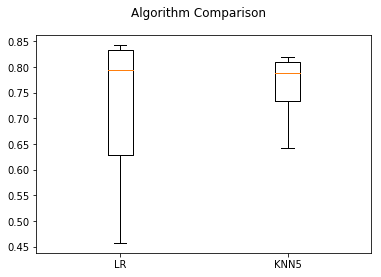

In [95]:
seed = 7
# prepare models
models = []
# models.append(('LinearSVC', LinearSVC()))
models.append(('LR', LogisticRegression()))
# models.append(('LDA', LinearDiscriminantAnalysis()))
# models.append(('KNN5', KNeighborsClassifier(n_neighbors=5, p=2)))
models.append(('KNN5', KNeighborsClassifier(n_neighbors=5, p=1)))
# models.append(('CART', DecisionTreeClassifier()))
# models.append(('NB', GaussianNB()))
# models.append(('LinearSVC', LinearSVC()))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_norm, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
#     if name == 'LR':
#         print cv_results
#         print model.densify()
#         raise
        
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [97]:
model = LogisticRegression()
model.fit(X_norm, Y)

a = zip(poly.get_feature_names(), model.coef_[0])
b = pd.DataFrame(data=a, columns=['feature', 'weight'])
b['abs_weight'] = np.absolute(b['weight'])

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)


features = {}
i = len(list(X_original.columns.values)) - 1
b['feature_desc'] = b['feature']
for feature_name in reversed(list(X_original.columns.values)):
    features['x'+str(i)] = feature_name
    b['feature_desc'] = b['feature_desc'].str.replace('x'+str(i), '{' + feature_name + '}')
    i = i - 1 
    
#print poly.get_feature_names()

print b.sort_values('abs_weight', ascending=False) 

      feature     weight  abs_weight                                                                                    feature_desc
6          x5 -12.312410   12.312410                                                                         {mean_total_chances_10}
116      x5^3  12.079213   12.079213                                                                       {mean_total_chances_10}^3
119      x6^3   9.153438    9.153438                                                            {correct_count/total_questions_10}^3
117   x5^2 x6   8.828652    8.828652                                    {mean_total_chances_10}^2 {correct_count/total_questions_10}
118   x5 x6^2  -7.786963    7.786963                                    {mean_total_chances_10} {correct_count/total_questions_10}^2
66    x1^2 x3   4.908824    4.908824                                              {correct_count_10}^2 {final_response_time_mean_10}
84    x1 x6^2  -4.890178    4.890178                                 

In [87]:
print len(X)

38184
